In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from IPython.display import clear_output
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm_notebook
from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from lightgbm import LGBMRegressor
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
warnings.filterwarnings("ignore")

In [7]:
ls -la Data_Calcium

total 24
drwxrwxr-x  6 ibulygin ibulygin 4096 дек.  25 19:21 ./
drwxrwx--- 12 ibulygin ibulygin 4096 февр. 23 20:58 ../
drwxrwxr-x  2 ibulygin ibulygin 4096 дек.   1 16:27 archive/
drwxrwx---  2 ibulygin ibulygin 4096 дек.  25 19:21 CA1_22-25_rears/
drwxrwxr-x  4 ibulygin ibulygin 4096 февр. 18 17:16 Circle/
drwxrwxr-x  2 ibulygin ibulygin 4096 дек.   1 16:27 Holy/


# Load data

In [12]:
spikes_df = pd.read_csv("./Data_Calcium/Circle/data/CA1_22_1D_initial_data.csv", index_col=0)
spikes_events_df = pd.read_csv("./Data_Calcium/Circle/spikes/CA1_22_1D_initial_data_spikes.csv", index_col=0)
print('n_steps', 'n_electrodes', spikes_df.shape)
trim=50
spikes_df = spikes_df[trim:-trim]
X = spikes_df.iloc[:,7:].to_numpy()
X_std = StandardScaler().fit_transform(X)

n_steps n_electrodes (18775, 556)


In [13]:
spikes_df

,time_s,x,y,x_green,y_green,x_red,y_red,0.0,1.0,2.0,...,539.0,540.0,541.0,542.0,543.0,544.0,545.0,546.0,547.0,548.0
50,53.35,705.002208,917.668306,740.947123,930.633705,729.660857,930.683773,0.34737,-0.249330,0.006592,...,0.217600,0.654160,-0.130430,0.026498,-1.048900,1.71920,-0.072928,0.242240,0.132260,-0.168190
51,53.40,705.177569,917.555411,741.035049,930.980894,729.732324,931.865336,0.44100,-0.067153,0.053535,...,-0.090382,0.457080,0.111480,0.008847,-0.087791,1.84910,-0.241060,0.159470,0.019400,0.259200
52,53.45,705.346104,917.433934,740.980720,931.333490,729.713544,933.095338,0.39963,-0.207070,0.151640,...,0.133350,1.033900,0.063393,0.166190,-0.841450,1.87420,-0.005210,0.215190,0.248840,-0.039980
53,53.50,705.499270,917.287861,740.829093,931.715928,729.651917,934.382987,0.38530,-0.155950,0.147590,...,-0.025291,0.362930,0.092240,-0.161670,-0.803850,1.95350,-0.010710,0.339760,-0.033023,-0.271240
54,53.55,705.621650,917.148704,740.629650,932.052229,729.569907,935.618318,0.26793,-0.050923,0.150580,...,0.226520,0.466490,0.030593,-0.140880,-0.257320,1.76550,-0.269020,0.103670,0.724710,-0.186040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18720,986.85,1013.520482,405.016239,1031.735816,433.791076,1023.504836,433.728392,0.41278,-0.285750,-0.866270,...,0.347480,-0.021572,-0.103220,0.104890,1.046000,-0.20997,-0.305730,-0.121770,-0.138290,0.256750
18721,986.90,1012.898615,403.616673,1031.229500,431.844331,1022.435070,431.838130,0.57755,-0.437350,-0.610490,...,0.942370,-0.283390,-0.136790,-0.303730,0.934520,-0.19970,-0.316170,0.119880,0.021649,-0.198300
18722,986.95,1012.262115,402.214095,1030.804303,429.595170,1020.937148,429.957049,0.53453,-0.412800,-0.600670,...,0.313020,-0.578810,-0.630350,-0.028785,-0.379270,-0.10065,-0.655350,-0.101830,0.332960,-0.357000
18723,987.00,1011.609982,400.852046,1030.460228,427.043592,1019.300967,428.183910,0.45245,-0.316220,-0.726520,...,0.552350,-0.464560,-0.560890,-0.149880,-0.508540,-0.27542,-0.451740,-0.386410,0.146520,-0.091156


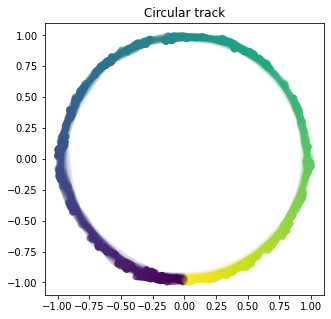

In [14]:
X = spikes_df["x"].to_numpy()
Y = spikes_df["y"].to_numpy()
X_green = spikes_df["x_green"].to_numpy()
Y_green = spikes_df["y_green"].to_numpy()
X_red = spikes_df["x_red"].to_numpy()
Y_red = spikes_df["y_red"].to_numpy()

coords = spikes_df[['x', 'y']].values
coords -= coords.mean(0)[None,:]
minmax_scaler = MinMaxScaler((-1,1))
coords_ = minmax_scaler.fit_transform(coords)
phi = np.arctan2(coords_[:,0], coords_[:,1])

plt.figure(figsize=(5,5))
plt.title("Circular track")
plt.scatter(coords_[:,0], coords_[:,1], alpha=0.05, c=phi)
plt.show()

In [15]:
X_std.shape

(18675, 549)

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, SpectralEmbedding as LaplacianEigenmaps
X_le_250 = np.load('./manifold_embeddings/X10_le_nn250.npy') #LaplacianEigenmaps(n_components=10, n_neighbors=250).fit_transform(X_std)
X_le_250_std = StandardScaler().fit_transform(X_le_250)

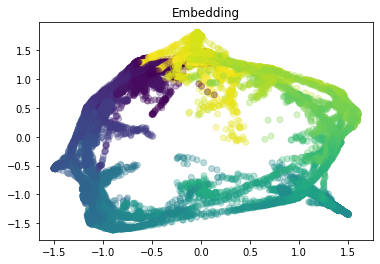

In [17]:
plt.scatter(X_le_250_std[:,0], X_le_250_std[:,1], alpha=0.3, c=phi)
plt.title('Embedding')
plt.show()

In [123]:
X_target_embedding = np.load('./embeddings/AE1024_dim-18_ep-700_MSE_TARGETS-xyav-signed.npy')
X_target_embedding_std = StandardScaler().fit_transform(X_target_embedding)

In [124]:
# speed sign
dphi = phi - np.concatenate([phi[0:1],phi[:-1]], axis=0)
dphi[dphi > 6] = -dphi[dphi > 6]
circle_sign = np.sign(dphi)

# speed
shift = coords_ - np.concatenate([coords_[0:1,:],coords_[:-1,:]], axis=0)
speed = (shift**2).sum(1) * circle_sign

# acceleration
speed_shift = np.concatenate(([speed[0]], speed))[:-1]
acceleration = speed - speed_shift

acceleration_ = MinMaxScaler((-1,1)).fit_transform(acceleration[:,None]).flatten()
speed_ = MinMaxScaler((-1,1)).fit_transform(speed[:,None]).flatten()

In [125]:
targets = {'x':coords_[:,0],
           'y':coords_[:,1],
           'speed':speed_,
           'acceleration':acceleration_}

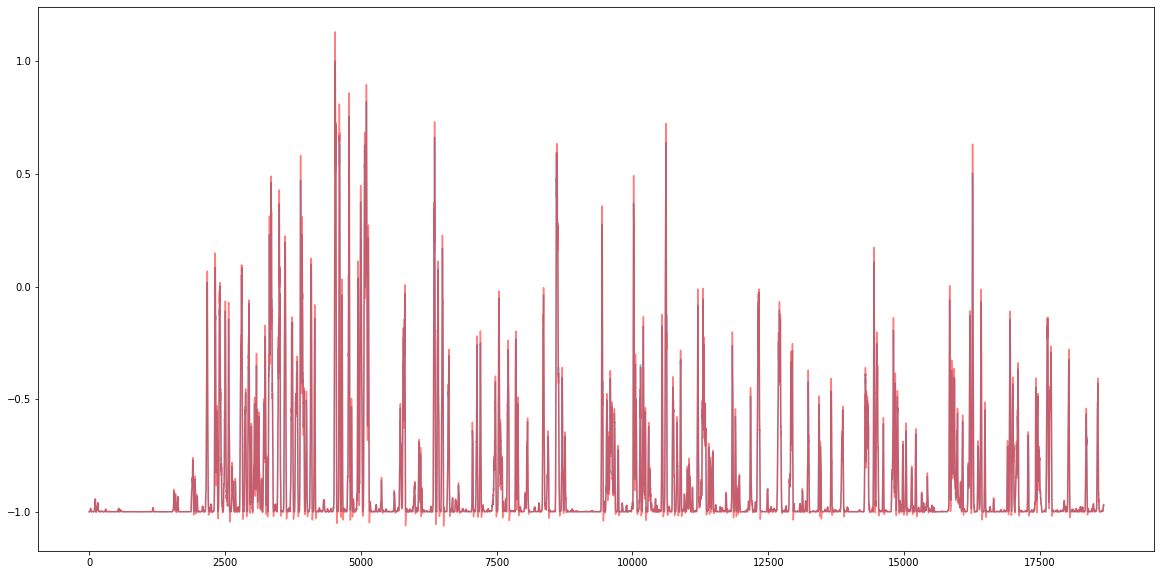

In [116]:
plt.figure(figsize=(20,10))
es = Holt(speed_).fit(smoothing_level=0.8, smoothing_trend=0.2)
plt.plot(speed_, alpha=0.5)
plt.plot(es.fittedvalues, 'r', alpha=0.5)
plt.show()

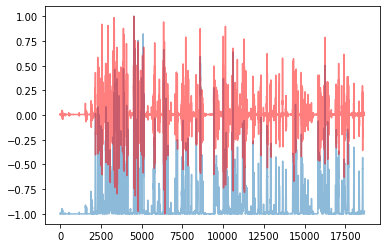

In [117]:
plt.plot(speed_, alpha=0.5)
plt.plot(acceleration_,'r', alpha=0.5)
plt.show()

# MLP model (baseline)

In [106]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim=2, hidden_dim=256):
        super().__init__() 
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layers =  nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.Linear(hidden_dim, output_dim))
        
        
    def forward(self, x):
        x = self.layers(x)
        return x
        

/media/hpc2_storage/ibulygin/miniconda3/envs/mink/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


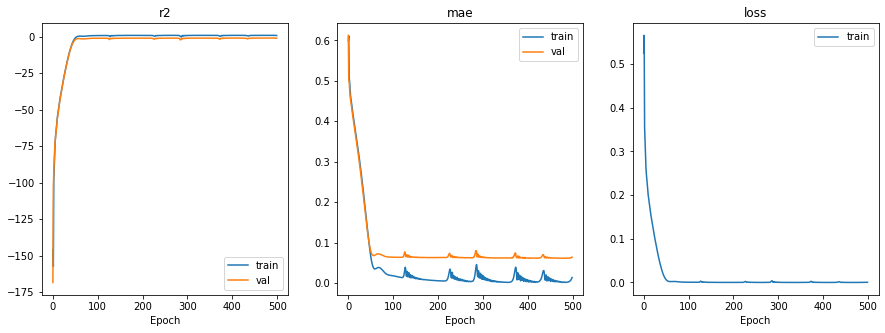

In [63]:
# define data
data_numpy = X_std
target_numpy = MinMaxScaler().fit_transform(acceleration[:,None]) #phi[:,None]

# train-test split
N = data_numpy.shape[0]
indexes = np.arange(N)
np.random.shuffle(indexes)
val_ratio = 0.1
split_index = int(val_ratio*N)
val_indexes = indexes[:split_index]
train_indexes = indexes[split_index:]   

data_tensor = torch.from_numpy(data_numpy).cuda().float()
data_val_tensor = data_tensor[val_indexes]
data_train_tensor = data_tensor[train_indexes]

target_tensor = torch.from_numpy(target_numpy).float().cuda()
target_val_tensor = target_tensor[val_indexes]
target_train_tensor = target_tensor[train_indexes]

model = MLP(data_numpy.shape[1], output_dim=target_numpy.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

history_train = defaultdict(list)
history_val = defaultdict(list)

for epoch in tqdm_notebook(range(500)):
    opt.zero_grad()
    pred_tensor = model(data_train_tensor)
    loss = criterion(target_train_tensor, pred_tensor)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    
    history_train['r2'].append(r2_score(target_train_tensor.detach().cpu().numpy(), 
                       pred_tensor.detach().cpu().numpy()))
    
    mae = torch.norm(target_train_tensor - pred_tensor, p=1, dim=1)
    history_train['mae'].append(mae.mean().item())
    history_train['loss'].append(loss.item())

    
    # validation
    with torch.no_grad():
        pred_tensor = model(data_val_tensor)

        history_val['r2'].append(r2_score(target_val_tensor.detach().cpu().numpy(), 
                                   pred_tensor.detach().cpu().numpy()))

        mae = torch.norm(target_val_tensor - pred_tensor, p=1, dim=1)
        history_val['mae'].append(mae.mean().item())
    

fig, axes = plt.subplots(nrows=1, ncols=len(history_train), figsize=(15,5))
for i,(k,v) in enumerate(history_train.items()):
    axes[i].plot(v, label='train')
    if k in history_val.keys():
        axes[i].plot(history_val[k], label='val')
    axes[i].set_xlabel('Epoch')
    axes[i].set_title(k)
    axes[i].legend()
plt.show()

# Sklearn models

In [126]:
data_numpy = X_target_embedding_std

In [127]:
r2_scorer = make_scorer(r2_score)
model = LGBMRegressor() #MultiOutputRegressor(Ridge())
# shuffle
N = data_numpy.shape[0]
indexes = np.arange(N)
np.random.shuffle(indexes)

data_numpy_shuffled = data_numpy[indexes]

for k,v in targets.items():
    target_shuffled = v[indexes] #+ 1e-5

    cv_results = cross_val_score(model, data_numpy_shuffled, target_shuffled, cv=10, verbose=False, scoring=r2_scorer)
    print(f'For {k}', cv_results.mean(), cv_results.std())

For x 0.9997712218598073 7.291373581589137e-06
For y 0.9998358212953363 9.612404220171763e-06
For speed 0.9827375821789095 0.01508576033155451
For acceleration 0.12741659800756394 0.33570878051756564


# Code Dim dependence

In [10]:
# dim_range = list(range(2,10,1)) + list(range(10,50,5))
# cv_r2_results_mean = []
# cv_r2_results_std = []
# for d in tqdm_notebook(dim_range):
#     embedding_numpy = np.load(f'./embeddings/AE512_dim-{d}_ep-500denoise-0.01_MSE.npy')
    
#     # shuffle
#     N = embedding_numpy.shape[0]
#     indexes = np.arange(N)
#     np.random.shuffle(indexes)

#     embedding_numpy_shuffled = embedding_numpy[indexes]
#     coords_shuffled = coords_[indexes]

#     cv_results = cross_val_score(model, embedding_numpy_shuffled, coords_shuffled, cv=10, verbose=False, scoring=r2_scorer)
#     cv_r2_results_mean.append(cv_results.mean())
#     cv_r2_results_std.append(cv_results.std())
    
# cv_r2_results_mean = np.array(cv_r2_results_mean)
# cv_r2_results_std = np.array(cv_r2_results_std)

In [11]:
# plt.plot(dim_range, cv_r2_results_mean)
# plt.fill_between(dim_range,
#                  cv_r2_results_mean - cv_r2_results_std, 
#                  cv_r2_results_mean + cv_r2_results_std,
#                  color='gray', 
#                  alpha=0.2)
# plt.ylabel('R2 score')
# plt.xlabel('embedding dim')
# plt.show()